In [257]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [258]:
# Dados de treino e teste
df_train = pd.read_csv('train.csv', sep="," , encoding="UTF8" )
df_test = pd.read_csv('test.csv', sep="," , encoding="UTF8" )

In [259]:
df_train.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


In [260]:
# Selecionando features por maior correlação
corr = df_train.corr()['NU_NOTA_MT'].sort_values(ascending=False)
features = corr.drop('TP_DEPENDENCIA_ADM_ESC').index[:10]
print('Features de maior correlação:')
set(features)

Features de maior correlação:


{'NU_NOTA_CH',
 'NU_NOTA_CN',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_LC',
 'NU_NOTA_MT',
 'NU_NOTA_REDACAO'}

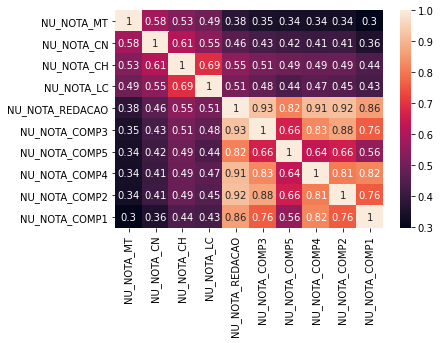

In [261]:
sns.heatmap(df_train[features].corr() ,  annot=True, annot_kws={"size": len(features)})

In [262]:
print('Nulos por variável (%):')
df_train[features].isna().sum()/df_train.shape[0]*100

Nulos por variável (%):


NU_NOTA_MT         26.198106
NU_NOTA_CN         24.683176
NU_NOTA_CH         24.683176
NU_NOTA_LC         26.198106
NU_NOTA_REDACAO    26.198106
NU_NOTA_COMP3      26.198106
NU_NOTA_COMP5      26.198106
NU_NOTA_COMP4      26.198106
NU_NOTA_COMP2      26.198106
NU_NOTA_COMP1      26.198106
dtype: float64

In [263]:
print('Zeros por variável (%):')
(df_train[features] == 0).sum()/df_train.shape[0]*100

Zeros por variável (%):


NU_NOTA_MT         0.072833
NU_NOTA_CN         0.050983
NU_NOTA_CH         0.021850
NU_NOTA_LC         0.050983
NU_NOTA_REDACAO    1.755280
NU_NOTA_COMP3      1.864530
NU_NOTA_COMP5      5.047342
NU_NOTA_COMP4      1.857247
NU_NOTA_COMP2      1.755280
NU_NOTA_COMP1      1.762564
dtype: float64

In [264]:
# Eliminando dados nulos do treino e teste
train = df_train[features].dropna()
vars_test = ['NU_INSCRICAO'] + list(features.drop('NU_NOTA_MT'))
test = df_test[vars_test].dropna()

In [265]:
test.head()

,NU_INSCRICAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,NU_NOTA_COMP3,NU_NOTA_COMP5,NU_NOTA_COMP4,NU_NOTA_COMP2,NU_NOTA_COMP1
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,464.8,443.5,431.8,420.0,80.0,40.0,100.0,80.0,120.0
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,391.1,491.1,548.0,580.0,120.0,100.0,120.0,120.0,120.0
2,b38a03232f43b11c9d0788abaf060f7366053b6d,595.9,622.7,613.6,320.0,40.0,80.0,80.0,40.0,80.0
4,715494628a50142ce8cb17191cfe6d0f3cae0934,592.9,492.6,571.4,320.0,60.0,0.0,80.0,80.0,100.0
5,e656d6bad65c93fb2880f1eba5037008c8e75774,414.5,568.5,542.5,560.0,120.0,80.0,120.0,120.0,120.0


In [266]:
# Definindo features de treino e target 
if 'NU_NOTA_MT' in features:
    features = features.drop('NU_NOTA_MT')
target = 'NU_NOTA_MT'
# Verificando se variáveis analisadas sestão presente em ambos arquivos de treino e teste
(set(features).issubset(set(df_train.columns)),
set(features).issubset(set(df_test.columns)))

(True, True)

In [267]:
# Montando dados para treino e teste do modelo
x_train = train[features]
y_train = train[target]
x_test = test[features]

In [268]:
# Padronizando...
sc = StandardScaler()  
x_train_norm = sc.fit_transform(x_train)
x_test_norm = sc.transform(x_test)

In [269]:
# Treino e predição: Random Forest
regressor = RandomForestRegressor(n_estimators=24, n_jobs=2, max_depth=19)
regressor.fit(x_train_norm, y_train)
test['NU_NOTA_MT'] = regressor.predict(x_test_norm)

In [270]:
# Adicionando valores previstos no dataset de teste (Obs: dados faltantes foram deixados como 0.00)
df_test['NU_NOTA_MT'] = np.round(0.0, 2)
for i in test.index:
    df_test.loc[i, 'NU_NOTA_MT'] = np.round(test['NU_NOTA_MT'][i], 2)

In [271]:
# Salvando resposta...
df_test[['NU_INSCRICAO', 'NU_NOTA_MT']].to_csv('answer.csv', index=False, header=True)

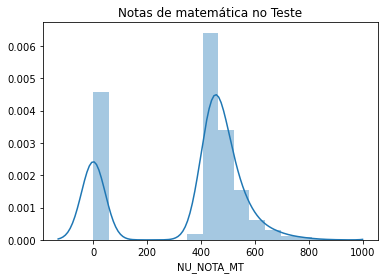

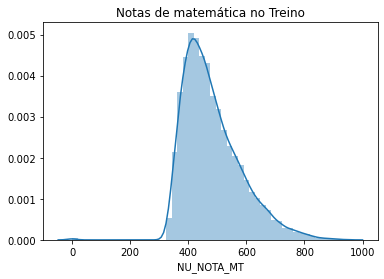

In [272]:
# Comparação entre notas de matemática de treino e teste através da distribuição
# 
fig1 = plt.figure()
plt.title('Notas de matemática no Teste')
sns.distplot(df_test['NU_NOTA_MT'])
fig2 = plt.figure()
plt.title('Notas de matemática no Treino')
sns.distplot(df_train['NU_NOTA_MT'])